# ANALISI ERR vs TEMP EXTRACTED per DIVERSE LEV_RED E NUM_PAIRS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


mother_dir = './NTempExtracted/'
n_sets = 5
a =['0.5','0.6','0.7','0.8', '0.9'] 
b = ['20', '40', '60', '80', '100']
lev_red_list = [ [],[],[],[],[] ]

for lev_red in a:
    for num_pairs in b:

        dir_name = f'{lev_red}_{num_pairs}'

        df_tot = pd.read_csv(mother_dir + f'{dir_name}/TotalStatics.csv', header=None, na_filter=False, index_col = 0)
        tot = (df_tot.to_numpy()).T
        df_numtemp = pd.read_csv(mother_dir + f'{dir_name}/NumberTempRedu.csv', header=None, na_filter = False, index_col = 0)
        numtemp = df_numtemp.to_numpy()

        x = np.arange(1, 77+1) 

        toremove = []
        for idx, i in enumerate(tot[0]):
            if i < 0.0001:
                toremove.append(idx)

        x = np.delete(x, toremove)
        tot = np.delete(tot, toremove, axis=1)
        numtemp = np.delete(numtemp, toremove, axis=1)

        temp_dict = {}
        temp_dict['x'] = x
        temp_dict['tot'] = tot
        temp_dict['numtemp'] = numtemp
        temp_dict['num_pairs'] = num_pairs

        lev_red_list[a.index(lev_red)].append(temp_dict)       

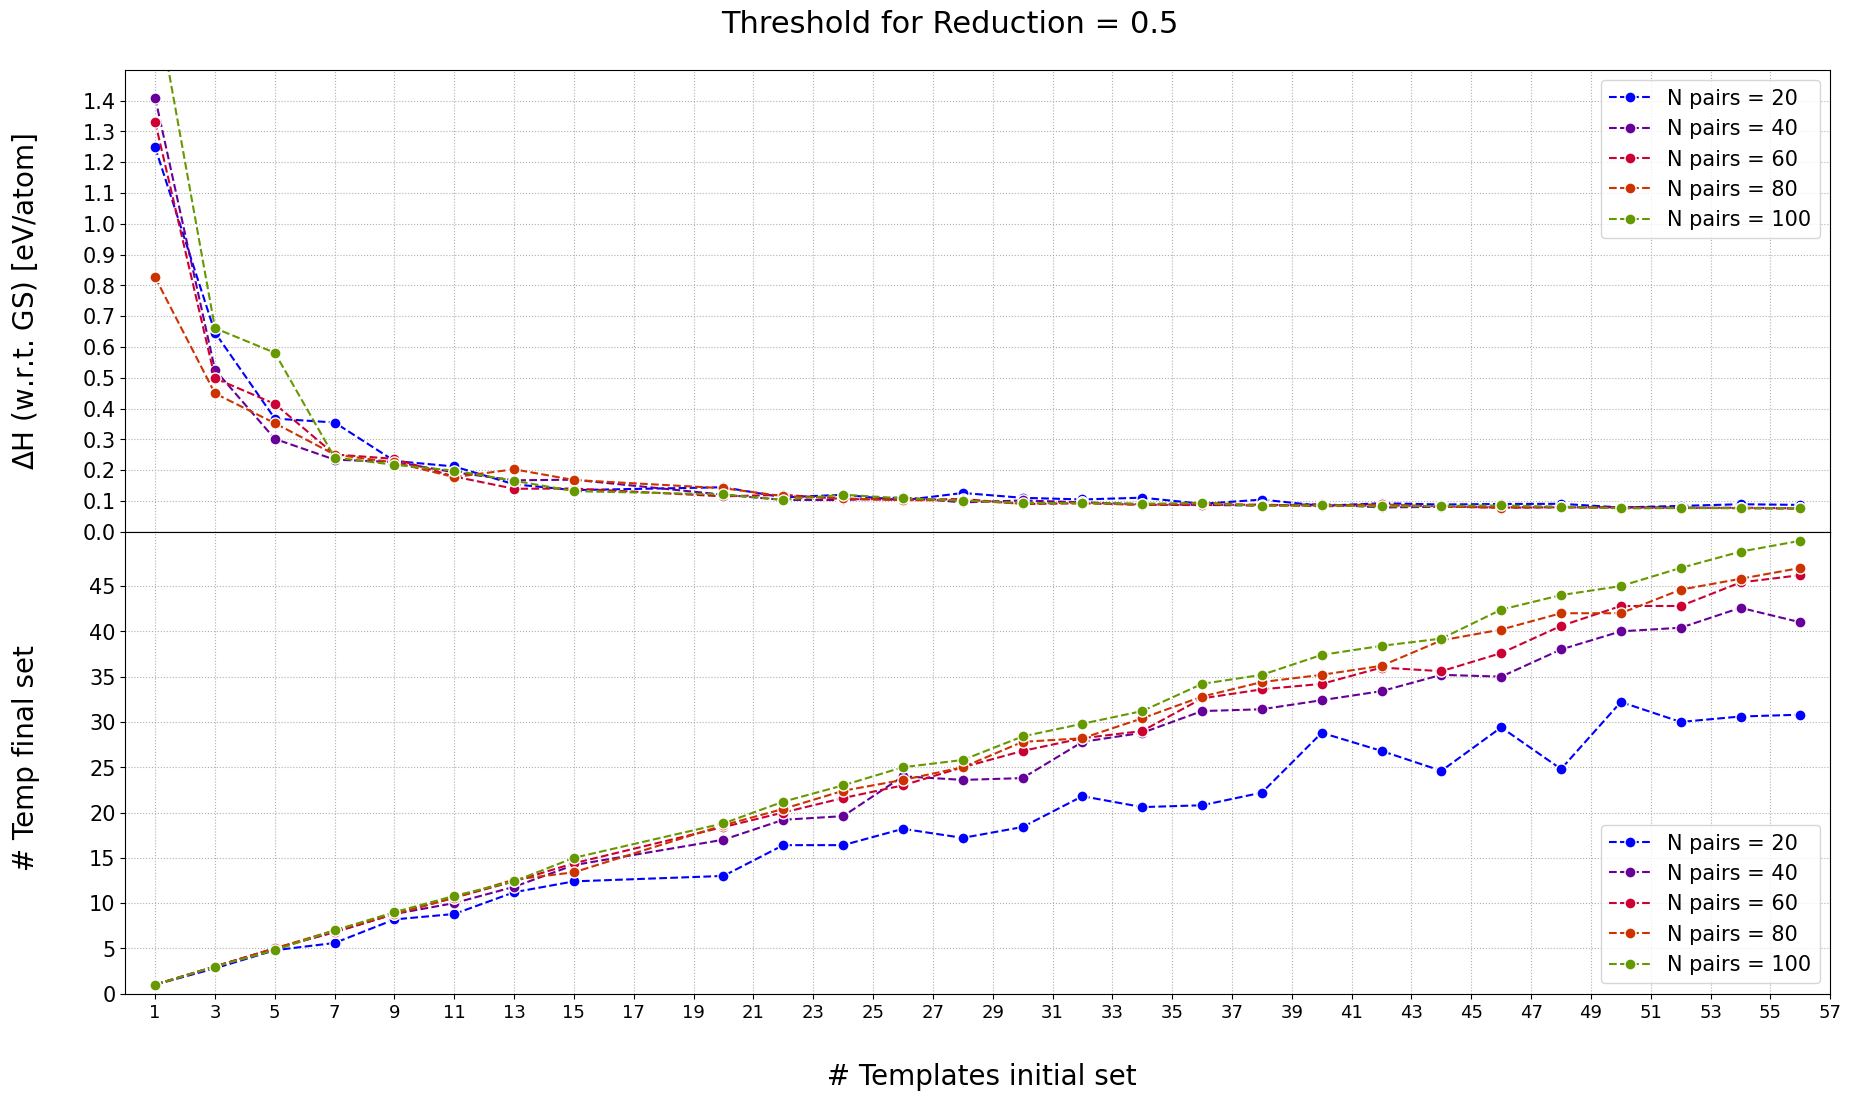

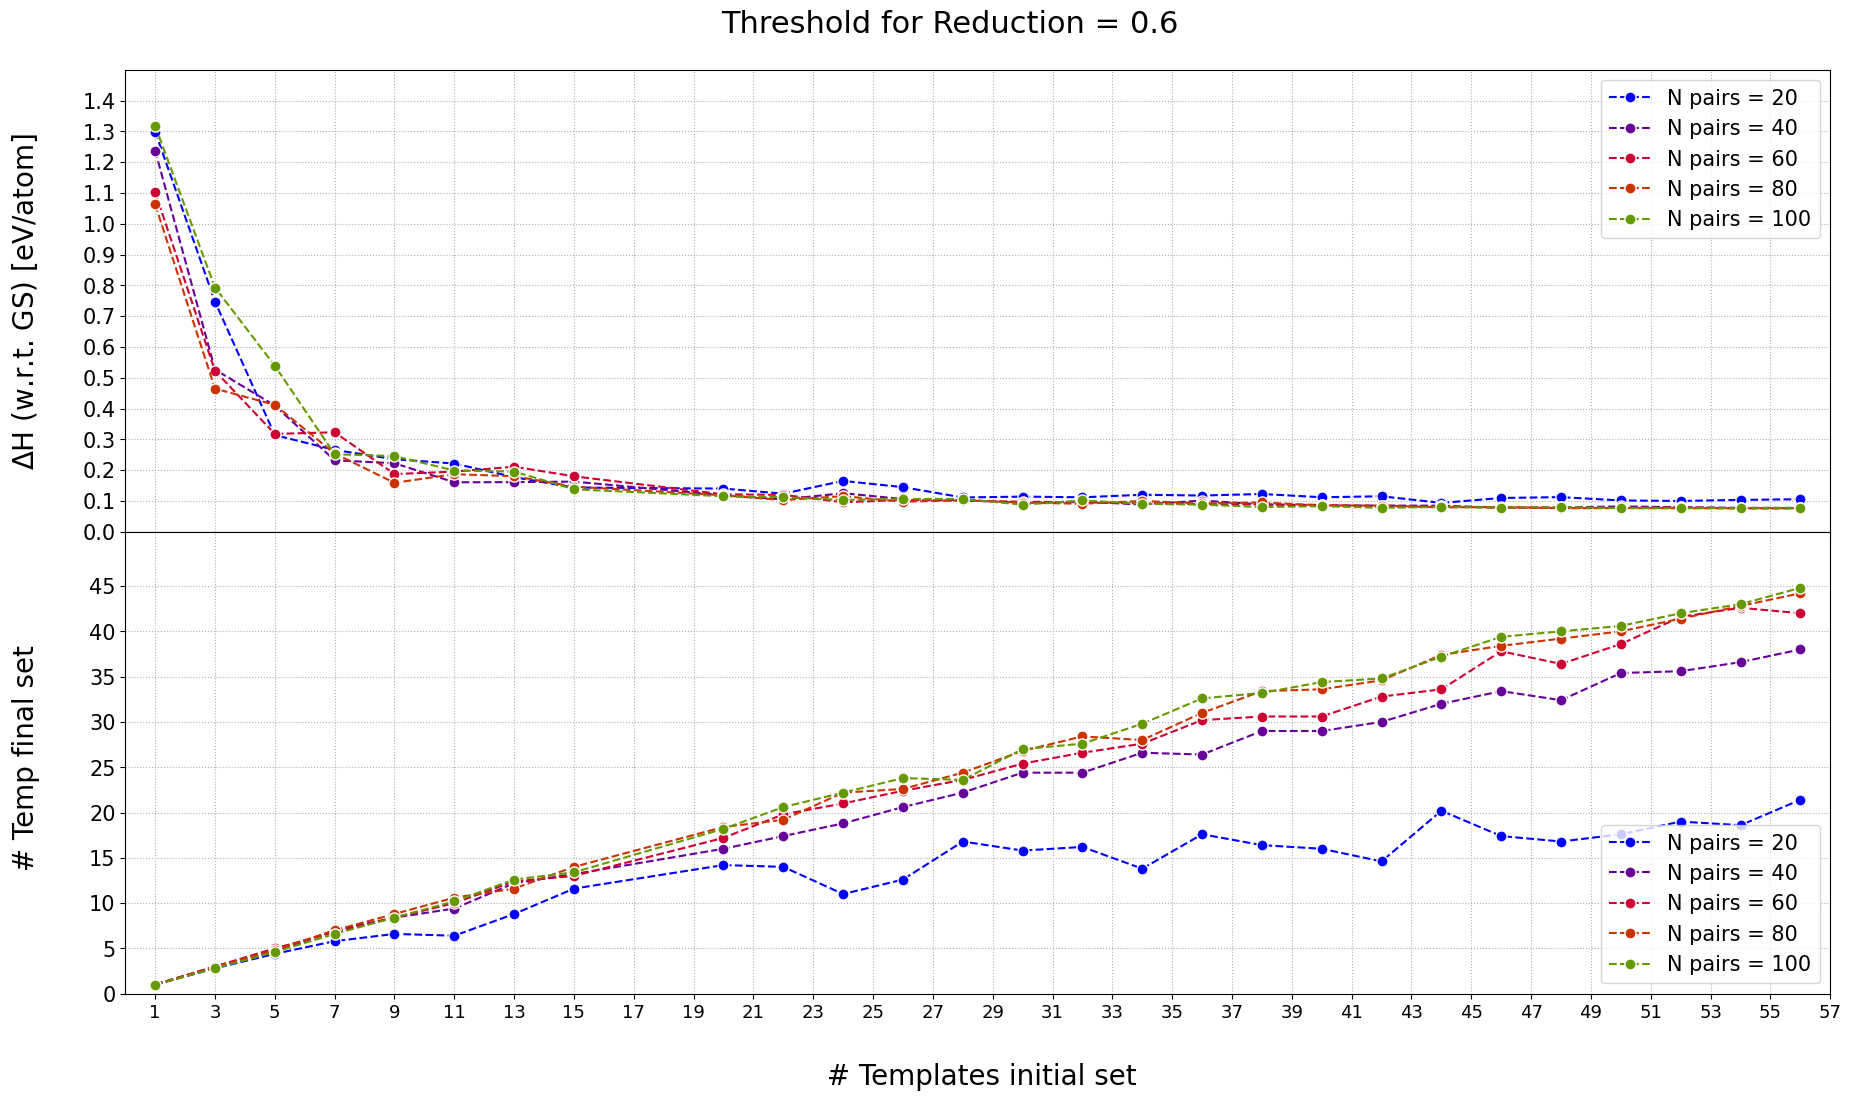

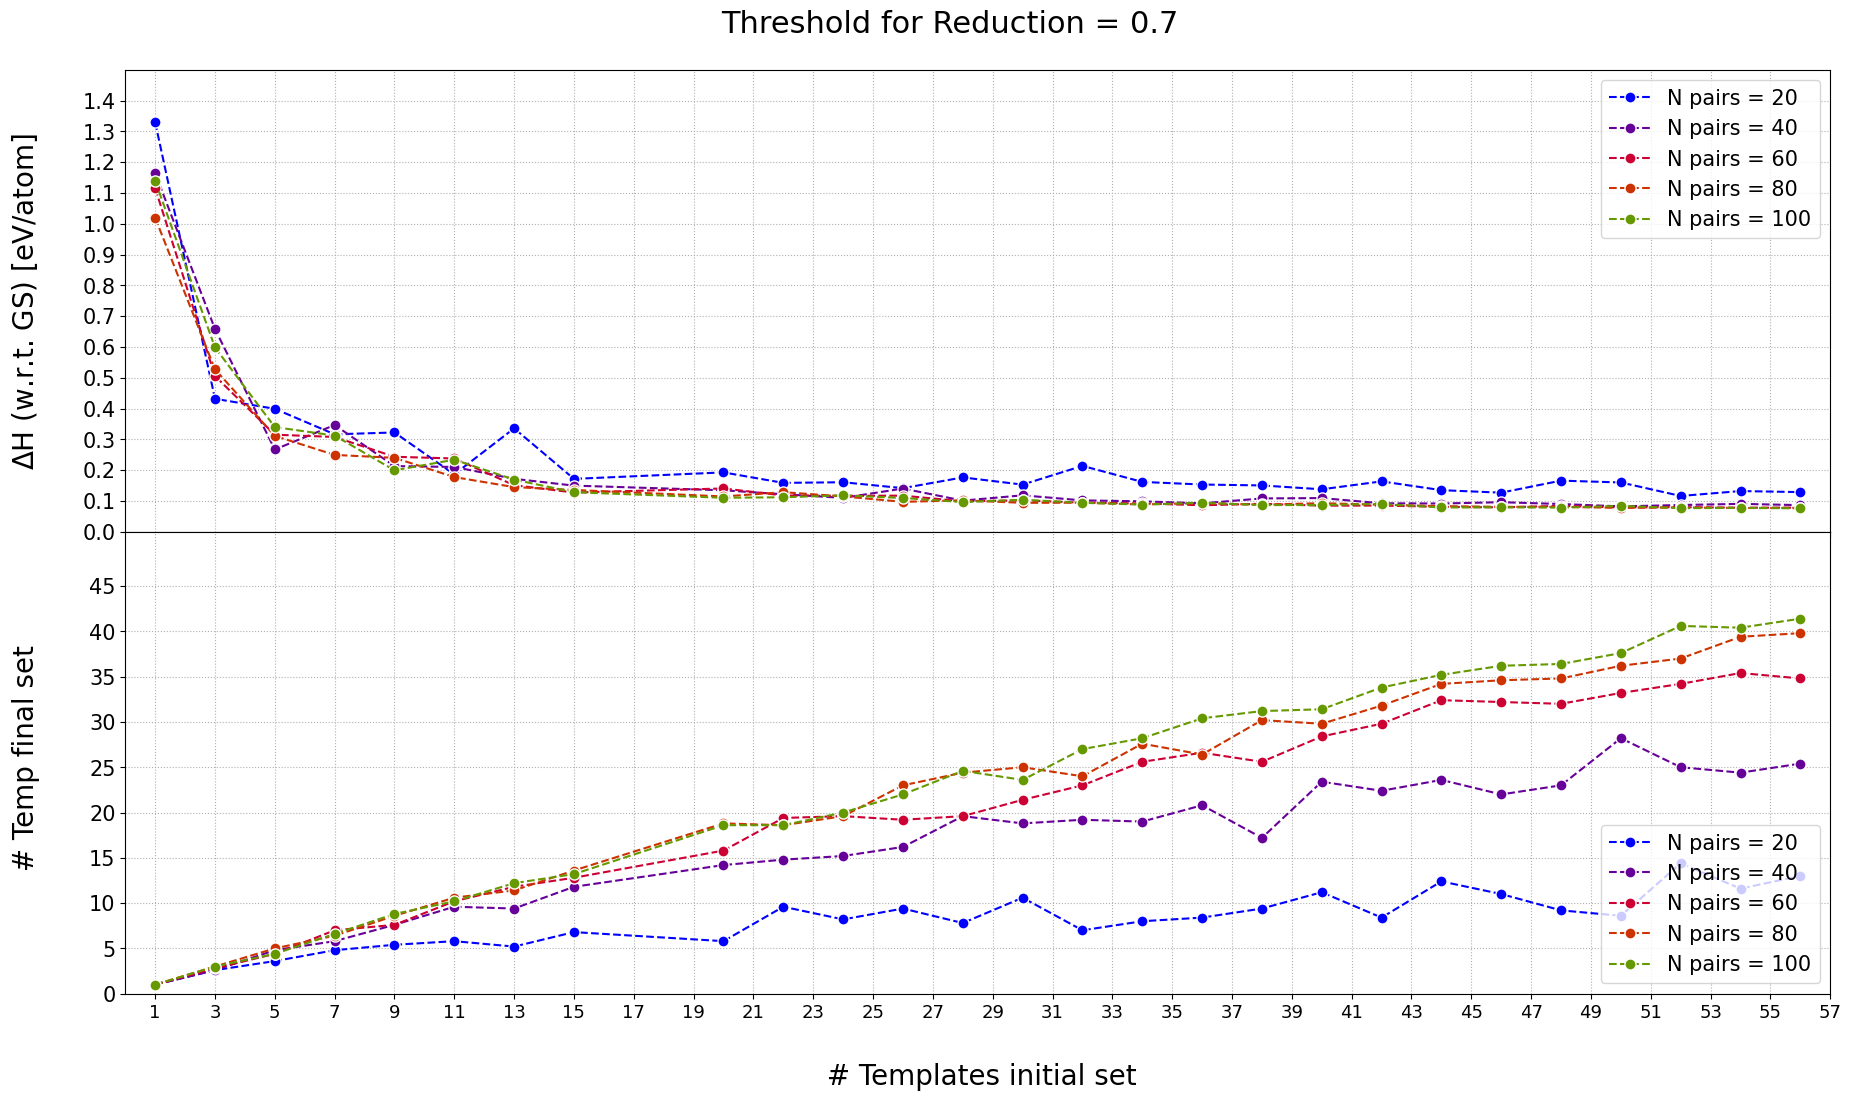

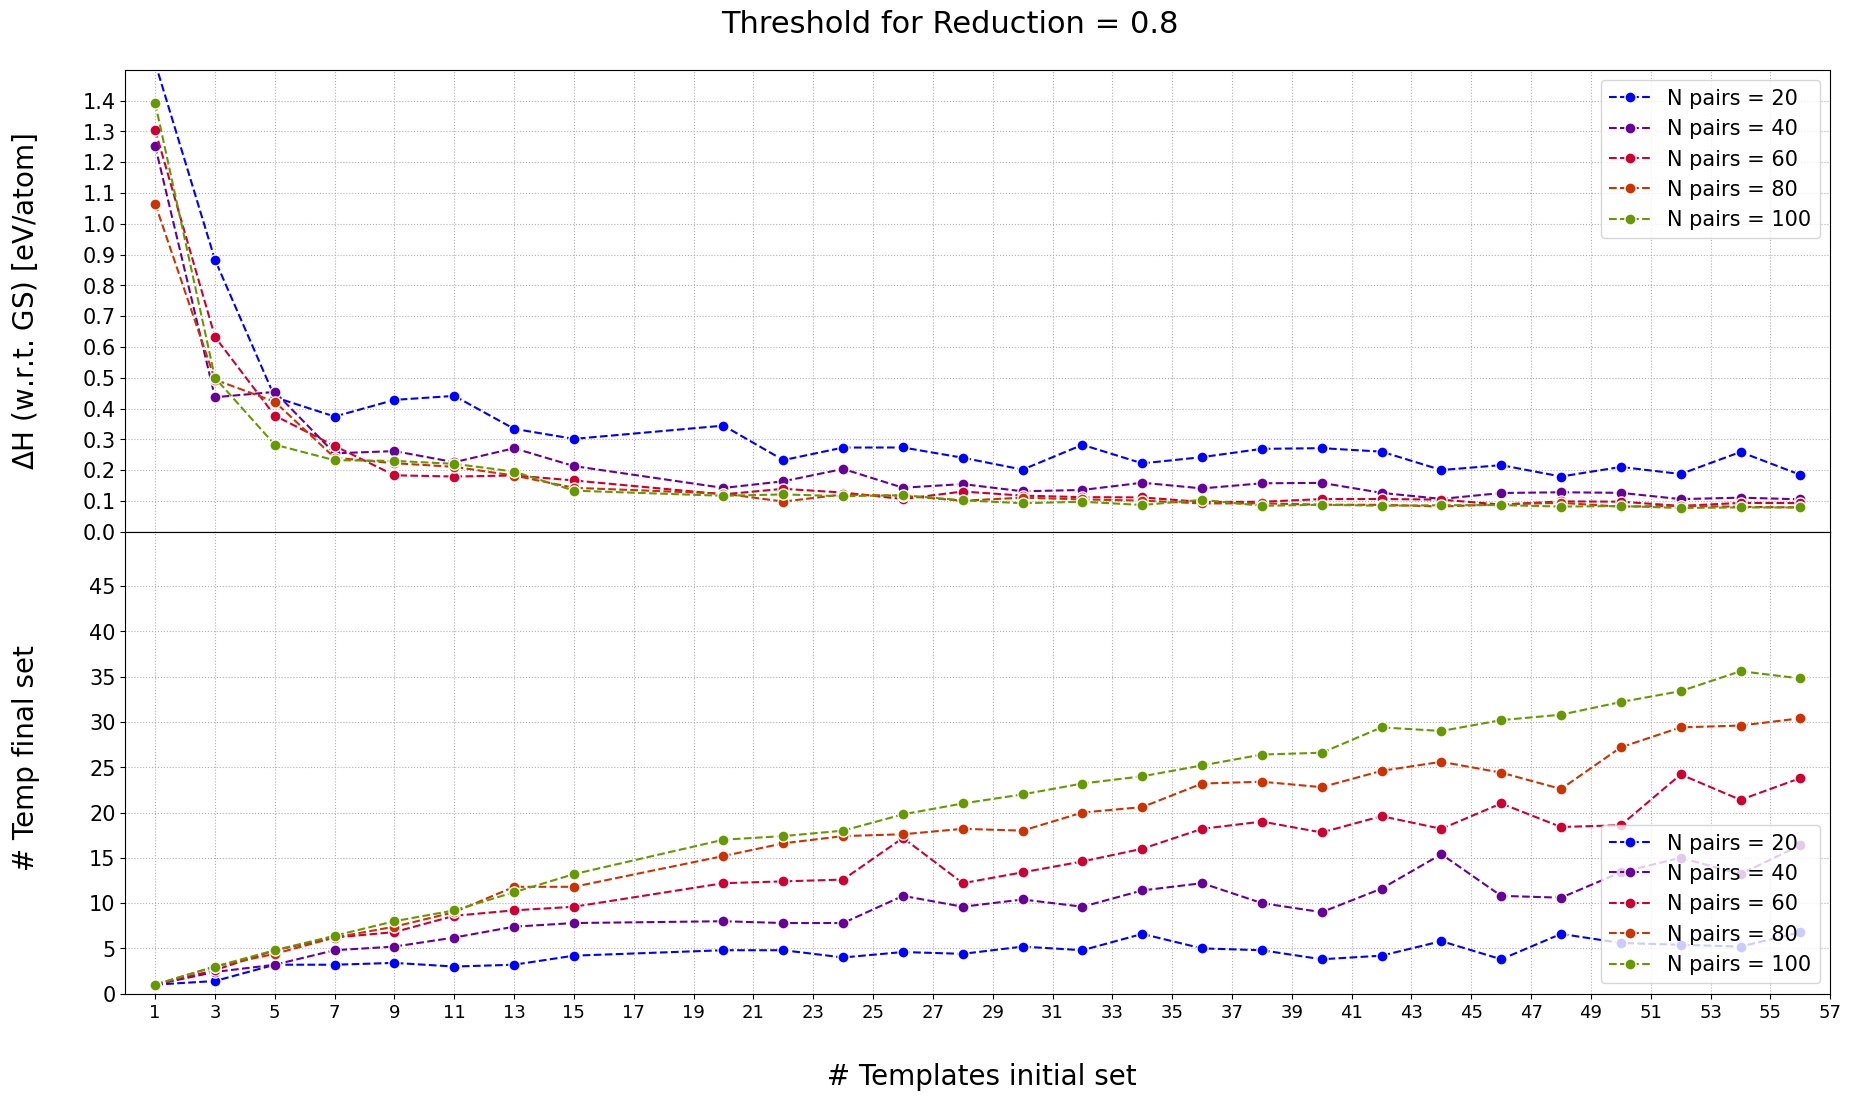

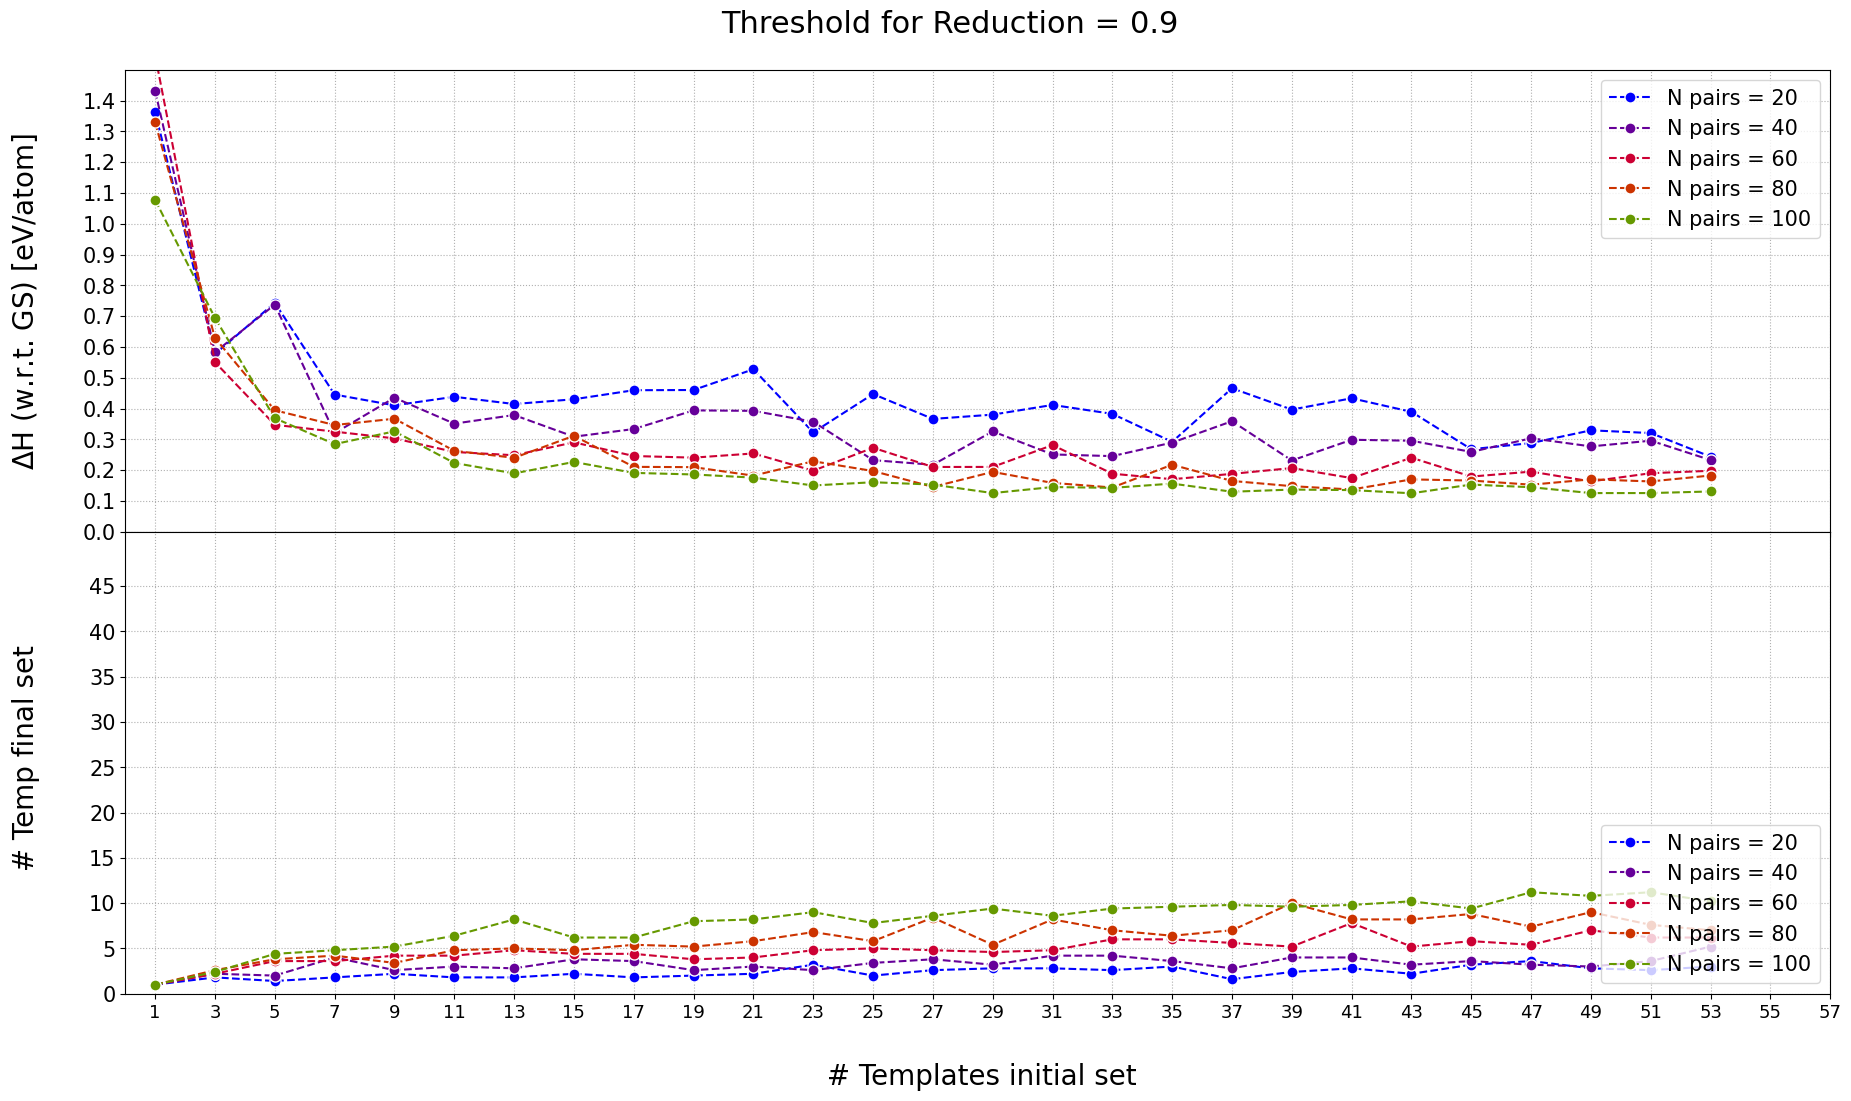

In [15]:
n_possible_couples = 105
names = ['0.5', '0.6', '0.7', '0.8', '0.9']
for idx, lev_red in enumerate(lev_red_list): 

    title = f'Threshold for Reduction = {names[idx]}'

    fig, (ax,ax1) = plt.subplots(2, 1, figsize=(22, 12), sharex=True) ## sharex=True to share the same x axis
    fig.subplots_adjust(hspace=0.0) ## space between subplots
    fig.suptitle(title, fontsize=22, y=0.93) ## title of the whole figure

    ax.grid(True, ls=':') ## grid for the first plot
    ax1.grid(True, ls=':')  ## grid for the second plot

    ax.set_ylabel(r'$\Delta$H (w.r.t. GS) [eV/atom]', fontsize=20) ## label of y axis
    ax.yaxis.set_label_coords(-0.05, 0.5) ## position of the label

    ## set the ticks for the y axis of the first plot
    step = 0.1 
    y_ticks  = np.arange(0.0, 1.5, step)
    y_ticks = np.round(y_ticks, decimals=1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks, fontsize=15)
    ax.set_ylim(0,1.5)

    ax1.set_ylabel(' # Temp final set', fontsize=20) ## label of y axis
    ax1.yaxis.set_label_coords(-0.05, 0.5) ## position of the label

    ## set the ticks for the y axis of the second plot
    step = 5
    y_ticks  = np.arange(0,50,step)
    y_ticks = np.round(y_ticks)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticks, fontsize=15)

    ax1.set_ylim(0,51)

    ## set the x axis label for both plots
    ax1.set_xlabel(' # Templates initial set', fontsize=20)
    ax1.xaxis.set_label_coords(0.5, -0.15)
    ax1.set_xticks(np.arange(1, 58, 2))
    ax1.set_xlim(0, 57)
    ax1.set_xticklabels(np.arange(1, 58, 2), fontsize=13, rotation=0)
    
    if idx == 4:
        n_possible_couples = 1
    ## plot the data
    for i in range(len(lev_red)):
        
        x = lev_red[i]['x']
        tot = lev_red[i]['tot']
        numtemp = lev_red[i]['numtemp']
        color = cm.brg(i/len(lev_red))
        ax.plot(x[:27], tot[0][:27]/n_possible_couples,ls = '--', color=color, marker='o', markeredgecolor='white', label = f'N pairs = {lev_red[i]["num_pairs"]}', markersize = 8 ) 
        ax1.plot(x[:27], numtemp[0][:27], color=color, ls='--', marker='o', markeredgecolor='white', label = f'N pairs = {lev_red[i]["num_pairs"]}', markersize = 8)

    ax.legend(fontsize=15, loc='upper right')
    ax1.legend(fontsize=15, loc='lower right')
    plt.show()
    fig.savefig(f'../LaTeX/Figure Risultati/{names[idx]}.png')




# ERR vs LEVRED WITH DIFFERENT NUMPAIRS

In [ ]:
### IN CASE PF ERRORS

from template_csp import managetemp as mte
import os 
import time
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']
temp_red = np.zeros((2,5,16))
en_err = np.zeros((2,5,16))

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 
    "n_sets" : 10,
}

for idx_lev, lev in enumerate(tqdm(range(60,91,2))):
    hyperparameters['lev_red'] = float(lev)/100

    for idx_npair, npair in enumerate(tqdm(range(20,101,20))):
        hyperparameters['n_pairs'] = npair
    
        errors = np.zeros(hyperparameters['n_sets'])
        tempafter = np.zeros(hyperparameters['n_sets'])

        for k in range(hyperparameters['n_sets']):
            hyperparameters['id_set'] = k

            template_set = mte.TemplateSet(test_elements, f'./LevRed_Npairs/{hyperparameters['lev_red']}_{npair}/TemplateSet_{k}')
            reduction_set = mte.PairSet(template_set, test_elements, f'./LevRed_Npairs/{hyperparameters['lev_red']}_{npair}/PairSet_{k}')

            errors[k] = reduction_set.total_error(hyperparameters) 
            tempafter[k] = len(reduction_set.reduced_set(hyperparameters))


        temp_red[0,idx_npair,idx_lev] = np.mean(tempafter)
        temp_red[1,idx_npair,idx_lev] = np.std(tempafter)

        # Errore totale con deviazione standard
        en_err[0,idx_npair,idx_lev] = np.mean(errors)
        en_err[1,idx_npair,idx_lev] = np.std(errors)
        
import pandas as pd
EnErrMean = pd.DataFrame(en_err[0])
EnErrStd = pd.DataFrame(en_err[1])

NTempMean = pd.DataFrame(temp_red[0])
NTempStd = pd.DataFrame(temp_red[1])

EnErrMean.to_csv('./LevRed_Npairs/EnErrMean.csv', header=None)
EnErrStd.to_csv('LevRed_Npairs/EnErrStd.csv', header=None)

NTempMean.to_csv('./LevRed_Npairs/NTempMean.csv', header=None)
NTempStd.to_csv('LevRed_Npairs/NTempStd.csv', header=None)

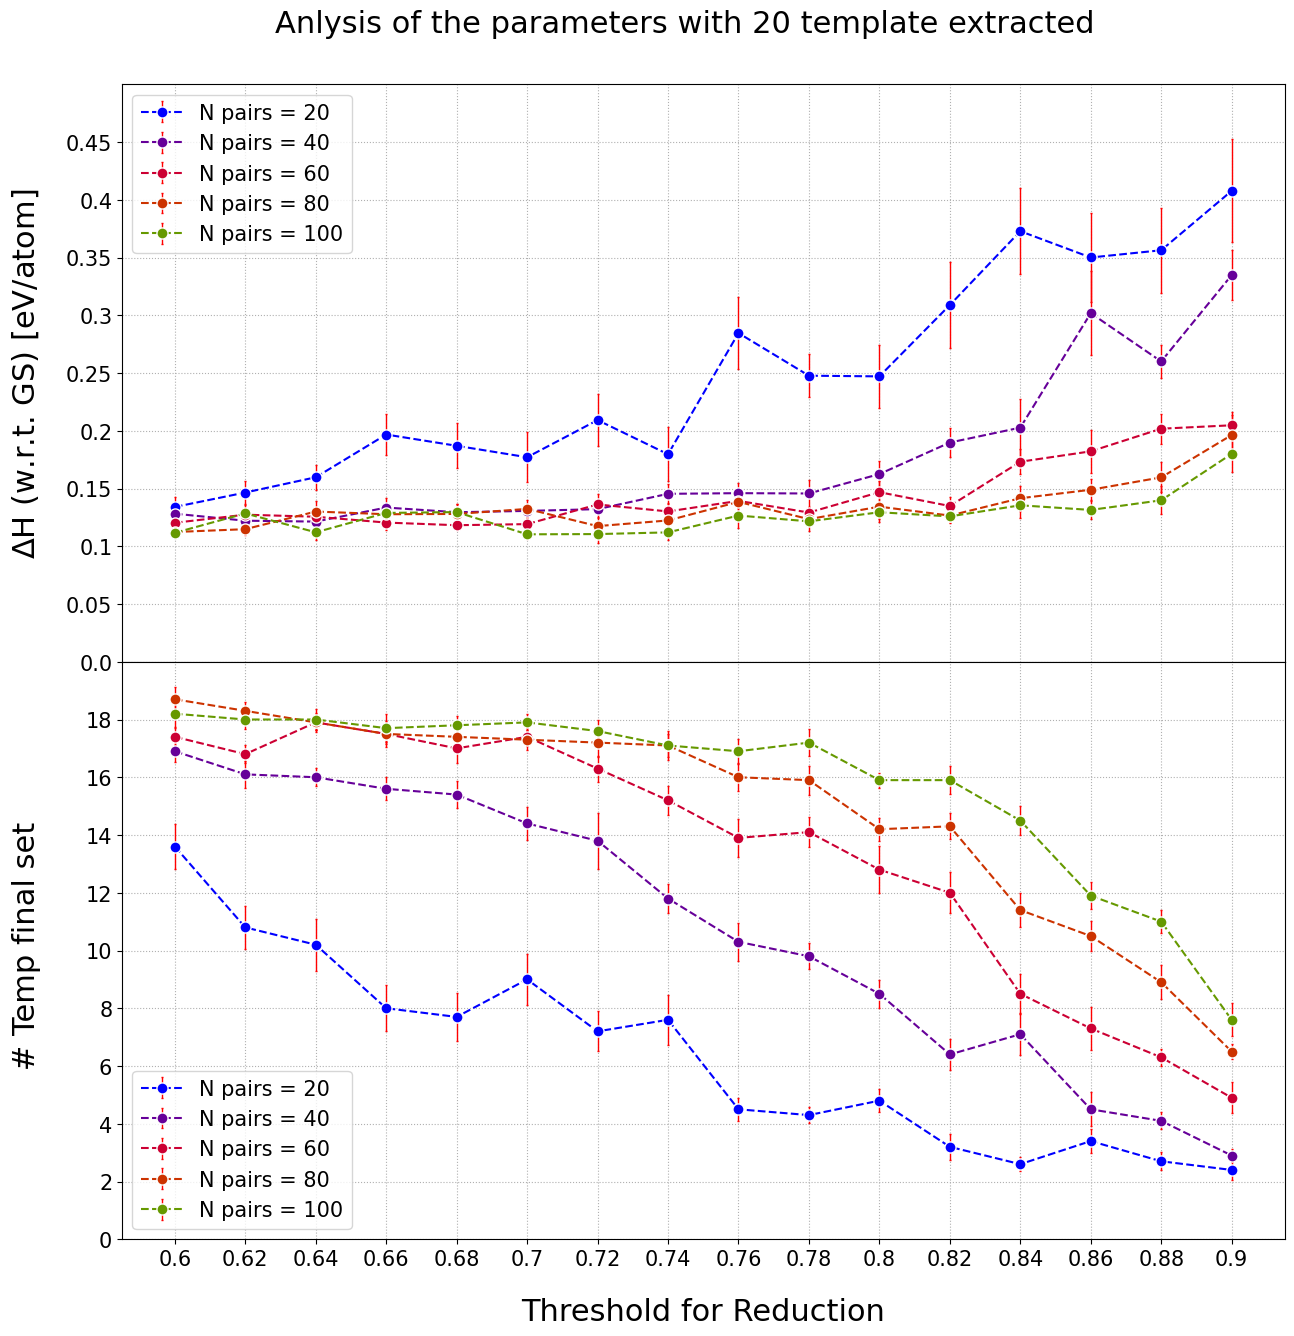

In [9]:
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm


Red_lev = np.round(np.arange(0.6, 0.91,0.02), decimals=2)
num_pairs = np.arange(20, 101, 20)
EnErrMean = pd.read_csv('LevRed_Npairs/EnErrMean.csv', header=None, na_filter=False, index_col=0)
EnErrMean = EnErrMean.to_numpy()
EnErrStd = pd.read_csv('LevRed_Npairs/EnErrStd.csv', header=None, na_filter=False, index_col=0)
EnErrStd = EnErrStd.to_numpy()
NTempMean = pd.read_csv('LevRed_Npairs/NTempMean.csv', header=None, na_filter=False, index_col=0)
NTempMean = NTempMean.to_numpy()
NTempStd = pd.read_csv('LevRed_Npairs/NTempStd.csv', header=None, na_filter=False, index_col=0)
NTempStd = NTempStd.to_numpy()

fig, (ax,ax1) = plt.subplots(2, 1, figsize=(15, 15), sharex=True) ## sharex=True to share the same x axis
fig.subplots_adjust(hspace=0.0) ## space between subplots
fig.suptitle('Anlysis of the parameters with 20 template extracted', fontsize=22, y=0.93) ## title of the whole figure

for i in range(len(num_pairs)):
    color = cm.brg(i/len(num_pairs))

    ax.errorbar(Red_lev, EnErrMean[i], yerr=EnErrStd[i]/10**0.5 ,ls = '--', ecolor='red', capsize=1, elinewidth=1, color=color, marker='o', markeredgecolor='white', label=f'N pairs = {num_pairs[i]}' , markersize = 8)
    ax1.errorbar(Red_lev, NTempMean[i], yerr=NTempStd[i]/10**0.5 , ls = '--', ecolor='red', capsize=1, elinewidth=1, color=color, marker='o', markeredgecolor='white', label=f'N pairs = {num_pairs[i]}' , markersize = 8)

ax.set_ylabel(r'$\Delta$H (w.r.t. GS) [eV/atom]', fontsize=22)
ax.yaxis.set_label_coords(-0.07, 0.5) ## position of the label
ax.set_ylim(0.0,0.5)
ax.set_yticks(np.round(np.arange(0.0,0.5,0.05), decimals=2))
ax.set_yticklabels(np.round(np.arange(0.0,0.5,0.05), decimals=2), fontsize=15)

ax1.set_ylabel(' # Temp final set', fontsize=22)
ax1.yaxis.set_label_coords(-0.07, 0.5)
ax1.set_xlabel('Threshold for Reduction', fontsize=22)
ax1.xaxis.set_label_coords(0.5, -0.1)

ax1.set_yticks(np.arange(0,20,2))
ax1.set_yticklabels(np.arange(0,20,2), fontsize=15)
ax1.set_ylim(0,20)

ax.legend(fontsize=15, loc='upper left')
ax1.legend(fontsize=15, loc='lower left')

ax1.set_xticks(Red_lev)
ax1.set_xticklabels(Red_lev, fontsize=15)

ax.grid(True, ls=':')
ax1.grid(True, ls=':')
fig.savefig('VariousLevRed.png')
plt.show()


# HIST OF EXTRACTION OF SYMMETRIES

In [2]:
from template_csp import managetemp as mte
import os 
import time
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']


hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1,
    "lev_red" : 0.9
}

In [ ]:
start_time = time.time()

for idx, j in enumerate(tqdm(range(100,19,-20))):
    hist_temp =  {}
    count = 0
    for i in tqdm(range(60, 81, 2)):
        for k in range(0,10):
            count+=1
            template_set = mte.TemplateSet(test_elements, f'./LevRed_Npairs/{float(i)/100}_{j}/TemplateSet_{k}')
            reduction_set = mte.PairSet(template_set, test_elements, f'./LevRed_Npairs/{float(i)/100}_{j}/PairSet_{k}')
            x = reduction_set.reduced_set(hyperparameters=hyperparameters)
            final_set = [a for a in template_set.couples if template_set.couples.index(a) in x]
            final_set = [f'{a[1]}' for a in final_set]
            for temp in final_set:
                if f'{temp}' in hist_temp.keys():
                    hist_temp[f'{temp}'] += 1
                else:
                    hist_temp[f'{temp}'] = 1
    x = []
    y = []
    for key in hist_temp.keys():
        x.append(key)
        y.append(hist_temp[key])

    x = np.array(x)
    y = np.array(y)/count
    
    index = np.argsort(y)[::-1]
    y = y[index]
    x = x[index]
    color = cm.brg(idx/5)
    fig, ax = plt.subplots(1,1, figsize=(20, 10))
    ax.set_title(f'LevRed = {hyperparameters["lev_red"]} and Npairs = {j}', fontsize=20, y=0.93)
    ax.bar(x,y, color=color, edgecolor ='black', linewidth = 1, label = f'Templates survived at least once = {len(x)}' )
    ax.set_xticks(x)
    ax.set_xlim(-1,len(x))
    ax.set_xticklabels((x), rotation=60, fontsize=8)
    ax.grid(True, ls=':')
    ax.legend(fontsize = 15, loc ='center right')
    fig.savefig(f'SymHist_LevRed_{hyperparameters["lev_red"]}_NumPairs_{j}.png')
    plt.show() 


# MATERIAL MAPS

In [2]:
from template_csp import managetemp as mte
from template_csp.managetemp import levensthein_distance
import numpy as np
import pandas as pd
import random
hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1,
    "lev_red" : 0.9
}
comp = 1
df = pd.read_csv(f'A{comp}B/relaxation/RELAX_DATA', sep=",", index_col=0, na_filter = False)
test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

template_set = mte.TemplateSet(test_elements, './FULLTRY/77/TemplateSet_1')
pairset = mte.PairSet(template_set, test_elements, './FULLTRY/77/PairSet_1')
reducted_set = pairset.reduced_set(hyperparameters)
subset_templates = [f'{template_set.couples[i][0][0]}{template_set.couples[i][0][1]}_{template_set.couples[i][1]}' for i in reducted_set]
n_temp_test = len(subset_templates)


# templates = []
# for idx,i in enumerate(template_set.couples):
#     templates.append(f'{i[0][0]}{i[0][1]}_{i[1]}')

# subset_templates = []
# n_temp_test = 10
# while len(subset_templates) < n_temp_test:
#     temp = np.random.choice([i for i in templates if i not in subset_templates])
#     subset_templates.append(temp)

pmatrix = {}
couples = np.array([])

for i in range(len(test_elements)):
    for j in range(i+1,len(test_elements)):
        couple = [test_elements[i],test_elements[j]]
        couple.sort()
        couple = ''.join(couple)
        pvec = np.zeros((2, len(subset_templates)))

        for idx, template in enumerate(subset_templates):
            pvec[0,idx] = df.loc[couple,template]
            pvec[1,idx] = idx
        
        sorted_idx = np.argsort(pvec[0])
        pvec[0] = pvec[0][sorted_idx]
        pvec[1] = pvec[1][sorted_idx]

        pmatrix[couple] = pvec
        couples = np.append(couples, couple)

lev_dist_matrix = np.zeros((len(couples), len(couples)))

for row, couple1 in enumerate(couples):
    for col, couple2 in enumerate(couples):
        if row == col:
            lev_dist_matrix[row,col] = 0
        else:
            lev_dist_matrix[row,col] = levensthein_distance(pmatrix[couple1][1], pmatrix[couple2][1]) 
print(len(subset_templates))

13


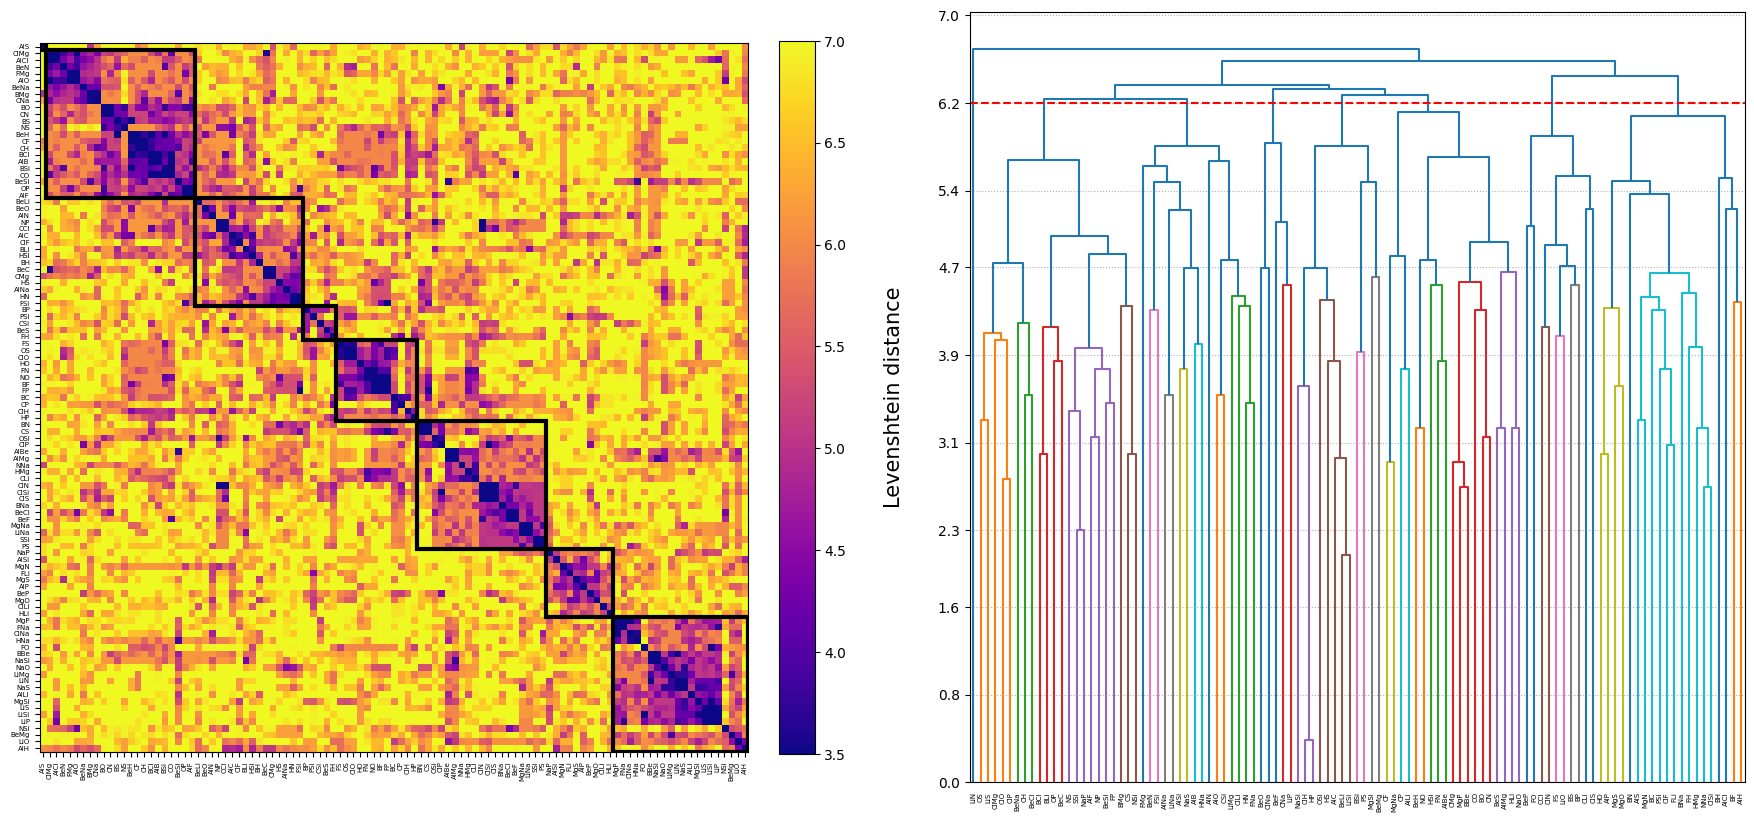

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.patches as patches

condensed_dist_matrix = squareform(lev_dist_matrix)
Z = linkage(condensed_dist_matrix, method='average')
dendro = dendrogram(Z, no_plot=True)
sorted_idx = dendro['leaves']
threshold = 6.2
cluster_labels = fcluster(Z, t=threshold, criterion="distance")

new = lev_dist_matrix[sorted_idx, :][:, sorted_idx]
cluster_labels_sorted = cluster_labels[sorted_idx]

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw={"width_ratios": [3, 3]})
im = ax.imshow(new, cmap='plasma') #or Spectral
im.set_clim((n_temp_test+1)/4, (n_temp_test+1)/2)

couples_in_clusters = []

unique_clusters = np.unique(cluster_labels_sorted)
for cluster in unique_clusters:
    # Trova gli indici che appartengono a questo cluster
    cluster_indices = np.where(cluster_labels_sorted == cluster)[0]
    if len(cluster_indices) > 0:
        # Trova il primo e l'ultimo elemento del cluster per i bordi
        start, end = cluster_indices[0], cluster_indices[-1]
        cluster_size = end - start + 1
        couples_in_clusters.append(np.array(couples)[sorted_idx][start:end+1])

        # Aggiungi un rettangolo per evidenziare il cluster con un piccolo offset
        rect = patches.Rectangle((start - 0.5, start - 0.5), cluster_size, cluster_size,
                                 linewidth=3, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

# Imposta i tick e mostra la figura
ax.set_xticks(np.arange(len(couples)))
ax.set_yticks(np.arange(len(couples)))
ax.set_xticklabels(np.array(couples)[sorted_idx], fontsize=5, rotation=90)
ax.set_yticklabels(np.array(couples)[sorted_idx], fontsize=5)
fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)


dendrogram(Z, labels=np.array(couples)[sorted_idx], leaf_rotation=90, leaf_font_size=5, ax=ax1)
ax1.axhline(y=threshold, color='r', linestyle='--')
ax1.set_ylabel('Levenshtein distance', fontsize=15)
ax1.yaxis.set_label_coords(-0.085, 0.5)
yticks = np.linspace(0, (n_temp_test+1)/2, 10)
yticks = np.round(yticks, decimals=1)
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=10)
ax1.grid(True, ls=':', axis='y')
plt.show()

In [5]:
import re

new_clusters = [np.array([])]
freq = [0]
for i in couples_in_clusters:
    if len(i) == 1:
        new_clusters[0] = np.append(new_clusters[0],i[0])
        freq[0]+=1./105
    else:
        new_clusters.append(i)
        freq.append(float(len(i))/105)
freq = np.array(freq)
sorted_idx = np.argsort(freq)
freq = freq[sorted_idx]
new_clusters = [new_clusters[i].tolist() for i in sorted_idx]
for idx, cluster in enumerate(new_clusters):
    new_clusters[idx] = [re.findall(r'[A-Z][^A-Z]*', j) for j in cluster]

clusters = {}
for i in range(len(freq)):
    clusters[f'{i}'] = {
        'couples' : new_clusters[i],
        'freq' : freq[i]
    }
import json
with open('clusters.json', 'w') as f:
    json.dump(clusters, f, indent=4)

In [6]:
with open('clusters.json', 'r') as f:
    clusters = json.load(f)
clusters

{'0': {'couples': [['Al', 'S']], 'freq': 0.009523809523809525},
 '1': {'couples': [['B', 'P'],
   ['P', 'Si'],
   ['C', 'Si'],
   ['Be', 'S'],
   ['F', 'H']],
  'freq': 0.047619047619047616},
 '2': {'couples': [['Na', 'P'],
   ['Al', 'Si'],
   ['Mg', 'N'],
   ['F', 'Li'],
   ['Mg', 'S'],
   ['Al', 'P'],
   ['Be', 'P'],
   ['Mg', 'O'],
   ['Cl', 'Li'],
   ['H', 'Li']],
  'freq': 0.09523809523809523},
 '3': {'couples': [['F', 'S'],
   ['O', 'S'],
   ['Cl', 'O'],
   ['H', 'O'],
   ['F', 'N'],
   ['N', 'O'],
   ['B', 'F'],
   ['F', 'P'],
   ['B', 'C'],
   ['C', 'P'],
   ['Cl', 'H'],
   ['H', 'P']],
  'freq': 0.11428571428571428},
 '4': {'couples': [['Be', 'Li'],
   ['Be', 'O'],
   ['Al', 'N'],
   ['N', 'P'],
   ['C', 'Cl'],
   ['Al', 'C'],
   ['Cl', 'F'],
   ['B', 'Li'],
   ['H', 'Si'],
   ['B', 'H'],
   ['Be', 'C'],
   ['C', 'Mg'],
   ['H', 'S'],
   ['Al', 'Na'],
   ['H', 'N'],
   ['F', 'Si']],
  'freq': 0.1523809523809524},
 '5': {'couples': [['B', 'N'],
   ['C', 'S'],
   ['O', 'Si'],
  